## Step 1:

### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from sklearn.metrics import accuracy_score

### Loading the Dataset :
### Dataset used: ambient_temperature_system_failure.csv
### dataset link: https://www.kaggle.com/datasets/boltzmannbrain/nab/data

In [68]:
file_path = "/kaggle/input/a2-input/ambient_temperature_system_failure.csv"
df = pd.read_csv(file_path)

print("Dataset Info:")
print(df.info())

print("First 5 rows:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None
First 5 rows:
             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551


### Printing the Dataset Statistics:

In [69]:
num_samples = df.shape[0]
num_features = df.shape[1]

print(f"Number of Samples: {num_samples}")
print(f"Number of Features: {num_features}")


Number of Samples: 7267
Number of Features: 2


In [70]:
stats = df['value'].describe()
print("Descriptive Statistics:")
print(stats)


Descriptive Statistics:
count    7267.000000
mean       71.242433
std         4.247509
min        57.458406
25%        68.369411
50%        71.858493
75%        74.430958
max        86.223213
Name: value, dtype: float64


#### The ambient temperature in an office setting. Recorded over 7267 instances in a time series. This datasets contains data in a real life scenario so we are using it to detect anomalies.

### Visualizations

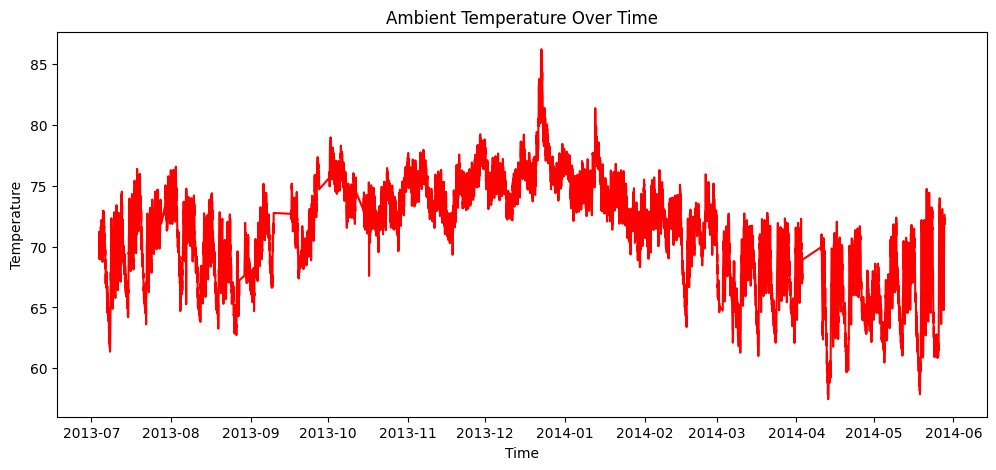

In [72]:
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['value'], color='red')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Ambient Temperature Over Time")
plt.show()


#### Temperature over time char showing the anomaly present at time between december 2013 and january 2014. The temperatue spiked above 85F

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


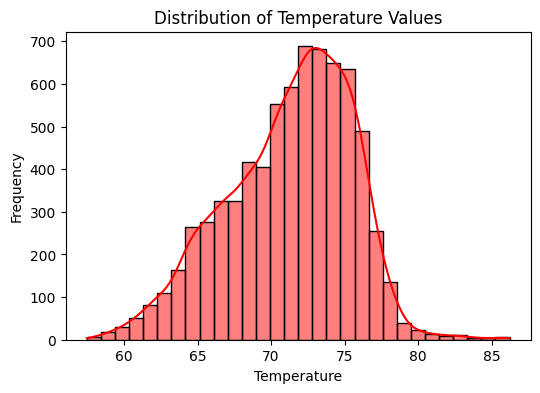

In [73]:
plt.figure(figsize=(6, 4))
sns.histplot(df['value'], bins=30, kde=True, color='red')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Distribution of Temperature Values")
plt.show()


#### Temperature distirbution chart showing the frequency of temperatures over the recorded values. A large bulk of recorded temperatures were between 70-78F with the highest frequency of about 600+ times recorded

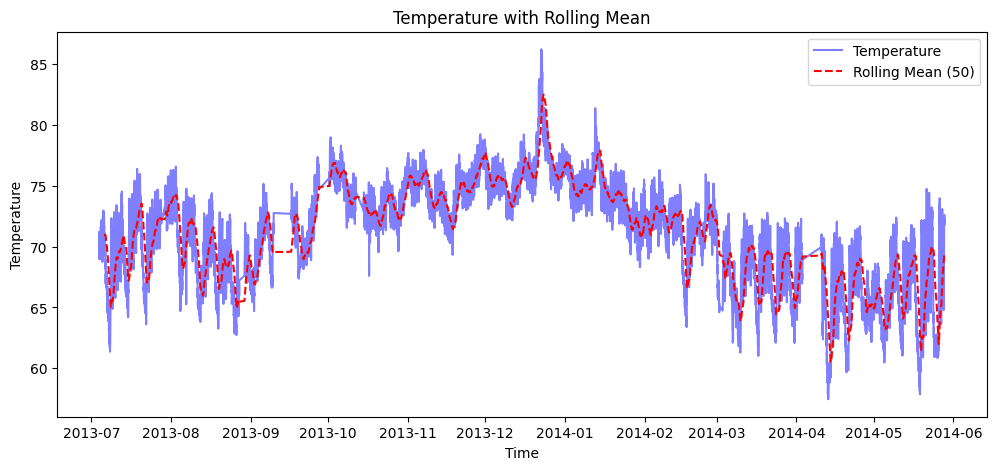

In [74]:
df['rolling_mean'] = df['value'].rolling(window=50).mean()

plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['value'], label="Temperature", color='blue', alpha=0.5)
plt.plot(df['timestamp'], df['rolling_mean'], label="Rolling Mean (50)", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperature with Rolling Mean")
plt.legend()
plt.show()


#### Temprature over time graph with rolling mean to further study how the means changed over time. This shows a much cleaner graph to analyze

### Checking for missing values

In [8]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
timestamp        0
value            0
rolling_mean    49
dtype: int64


In [75]:
df['rolling_mean'] = df['rolling_mean'].ffill()

df['rolling_mean'] = df['rolling_mean'].bfill()

In [76]:
print("Missing Values after Imputation:")
print(df.isnull().sum().sum())

Missing Values after Imputation:
0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     7267 non-null   datetime64[ns]
 1   value         7267 non-null   float64       
 2   rolling_mean  7267 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 170.4 KB


### Normalization of the data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_normalize = ['value', 'rolling_mean']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


In [13]:
df.describe()

,timestamp,value,rolling_mean
count,7267,7267.000000,7267.000000
mean,2013-12-17 01:43:01.477914112,0.479198,0.488236
min,2013-07-04 00:00:00,0.000000,0.000000
25%,2013-10-01 13:30:00,0.379318,0.359947
50%,2013-12-19 04:00:00,0.500615,0.510482
75%,2014-03-06 01:30:00,0.590046,0.626407
max,2014-05-28 15:00:00,1.000000,1.000000
std,NaN,0.147663,0.175206


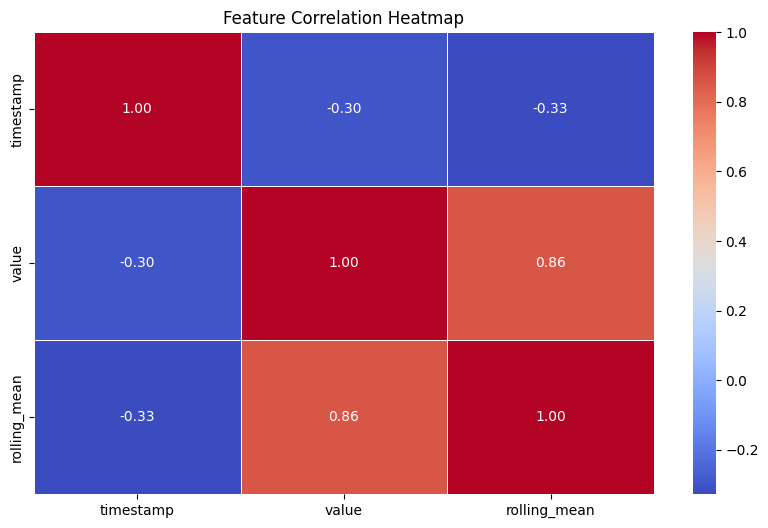

In [14]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


### Splitting the Data as Train, Val and Test

In [77]:
features = ["value", "rolling_mean"]
X = df[features].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp = train_test_split(X_scaled, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32).reshape(-1, len(features))
X_val_t = torch.tensor(X_val, dtype=torch.float32).reshape(-1, len(features))
X_test_t = torch.tensor(X_test, dtype=torch.float32).reshape(-1, len(features))

train_loader = DataLoader(TensorDataset(X_train_t, X_train_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, X_val_t), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, X_test_t), batch_size=32, shuffle=False)


## Step 2

### Model 1 - Defined

In [30]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),  
            nn.ReLU(),
            nn.Linear(64, 32),  
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )


        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim),
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(32, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 2]                   --
├─Sequential: 1-1                        [32, 2]                   --
│    └─Linear: 2-1                       [32, 64]                  192
│    └─ReLU: 2-2                         [32, 64]                  --
│    └─Linear: 2-3                       [32, 32]                  2,080
│    └─ReLU: 2-4                         [32, 32]                  --
│    └─Linear: 2-5                       [32, 16]                  528
│    └─ReLU: 2-6                         [32, 16]                  --
│    └─Linear: 2-7                       [32, 8]                   136
│    └─ReLU: 2-8                         [32, 8]                   --
│    └─Linear: 2-9                       [32, 2]                   18
├─Sequential: 1-2                        [32, 2]                   --
│    └─Linear: 2-10                      [32, 4]                   12
│    └─Re

### Defining training function along with early stopping

In [37]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001):

        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  
        else:
            self.counter += 1  
            if self.counter >= self.patience:
                self.early_stop = True


In [38]:
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=5):
    model.to(device)
    history = {'train_loss': [], 'val_loss': []}
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs = batch[0].to(device)

            if inputs.dim() == 2:
                inputs = inputs.unsqueeze(1)  

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                if inputs.dim() == 2:
                    inputs = inputs.unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break 

    return history


### Model 1 training

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_fc = Autoencoder(input_dim)
optimizer_fc = optim.Adam(model_fc.parameters(), lr=0.005)

history_fc = train_autoencoder(model_fc, train_loader, val_loader, nn.MSELoss(), optimizer_fc, device, patience=3)


Epoch 1/20, Train Loss: 0.0101, Val Loss: 0.0019
Epoch 2/20, Train Loss: 0.0019, Val Loss: 0.0018
Epoch 3/20, Train Loss: 0.0019, Val Loss: 0.0017
Epoch 4/20, Train Loss: 0.0019, Val Loss: 0.0017
Epoch 5/20, Train Loss: 0.0018, Val Loss: 0.0016
Epoch 6/20, Train Loss: 0.0017, Val Loss: 0.0015
Epoch 7/20, Train Loss: 0.0016, Val Loss: 0.0015
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0014
Epoch 9/20, Train Loss: 0.0015, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010
Early stopping at epoch 13


### Model 2 Defined

In [43]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=16):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.decoder = nn.LSTM(input_size=hidden_size, hidden_size=input_size, num_layers=1, batch_first=True)

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.decoder(x)
        return x


X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1) 

input_dim = X_tensor.shape[-1]
model_lstm = LSTMAutoencoder(input_size=input_dim)

summary(model_lstm, input_size=(32, X_tensor.shape[1], input_dim)) 


Layer (type:depth-idx)                   Output Shape              Param #
LSTMAutoencoder                          [32, 1, 2]                --
├─LSTM: 1-1                              [32, 1, 16]               1,280
├─LSTM: 1-2                              [32, 1, 2]                160
Total params: 1,440
Trainable params: 1,440
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

### Training model 2

In [44]:
model_lstm = LSTMAutoencoder(input_size=input_dim)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)
history_lstm = train_autoencoder(model_lstm, train_loader, val_loader, nn.MSELoss(), optimizer_lstm, device, patience=3)


Epoch 1/20, Train Loss: 0.1155, Val Loss: 0.0333
Epoch 2/20, Train Loss: 0.0210, Val Loss: 0.0170
Epoch 3/20, Train Loss: 0.0168, Val Loss: 0.0140
Epoch 4/20, Train Loss: 0.0129, Val Loss: 0.0098
Epoch 5/20, Train Loss: 0.0080, Val Loss: 0.0054
Epoch 6/20, Train Loss: 0.0056, Val Loss: 0.0051
Epoch 7/20, Train Loss: 0.0052, Val Loss: 0.0048
Epoch 8/20, Train Loss: 0.0049, Val Loss: 0.0045
Epoch 9/20, Train Loss: 0.0046, Val Loss: 0.0042
Epoch 10/20, Train Loss: 0.0043, Val Loss: 0.0039
Epoch 11/20, Train Loss: 0.0041, Val Loss: 0.0039
Epoch 12/20, Train Loss: 0.0041, Val Loss: 0.0039
Epoch 13/20, Train Loss: 0.0041, Val Loss: 0.0038
Early stopping at epoch 13


### Model 3 Defined

In [45]:
class Conv1DAutoencoderReLU(nn.Module):
    def __init__(self, input_size):
        super(Conv1DAutoencoderReLU, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),  
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),  
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = 64 
model_conv1d_relu = Conv1DAutoencoderReLU(input_size=input_dim)

from torchinfo import summary
summary(model_conv1d_relu, input_size=(32, 1, input_dim))  


Layer (type:depth-idx)                   Output Shape              Param #
Conv1DAutoencoderReLU                    [32, 1, 64]               --
├─Sequential: 1-1                        [32, 32, 64]              --
│    └─Conv1d: 2-1                       [32, 16, 64]              64
│    └─ReLU: 2-2                         [32, 16, 64]              --
│    └─Dropout: 2-3                      [32, 16, 64]              --
│    └─Conv1d: 2-4                       [32, 32, 64]              1,568
│    └─ReLU: 2-5                         [32, 32, 64]              --
├─Sequential: 1-2                        [32, 1, 64]               --
│    └─Conv1d: 2-6                       [32, 16, 64]              1,552
│    └─ReLU: 2-7                         [32, 16, 64]              --
│    └─Conv1d: 2-8                       [32, 1, 64]               49
│    └─Sigmoid: 2-9                      [32, 1, 64]               --
Total params: 3,233
Trainable params: 3,233
Non-trainable params: 0
Total mult-

### Model 3 training

In [47]:

model_conv1d = Conv1DAutoencoderReLU(input_size=input_dim)
optimizer_conv1d = optim.Adam(model_conv1d.parameters(), lr=0.001)
history_conv1d = train_autoencoder(model_conv1d, train_loader, val_loader, nn.MSELoss(), optimizer_conv1d, device, patience=3)


Epoch 1/20, Train Loss: 0.0111, Val Loss: 0.0019
Epoch 2/20, Train Loss: 0.0034, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0026, Val Loss: 0.0014
Epoch 4/20, Train Loss: 0.0019, Val Loss: 0.0006
Epoch 5/20, Train Loss: 0.0015, Val Loss: 0.0004
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0007
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0007
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0006
Early stopping at epoch 8


### Saving the best model

In [60]:
torch.save(model_fc.state_dict(), "a2_part2_ithamizh_kisorese.pt")

### Function to plot training and validation loss of 3 models

In [50]:
def plot_loss_curves(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


### Model 3 : Conv1D Plot

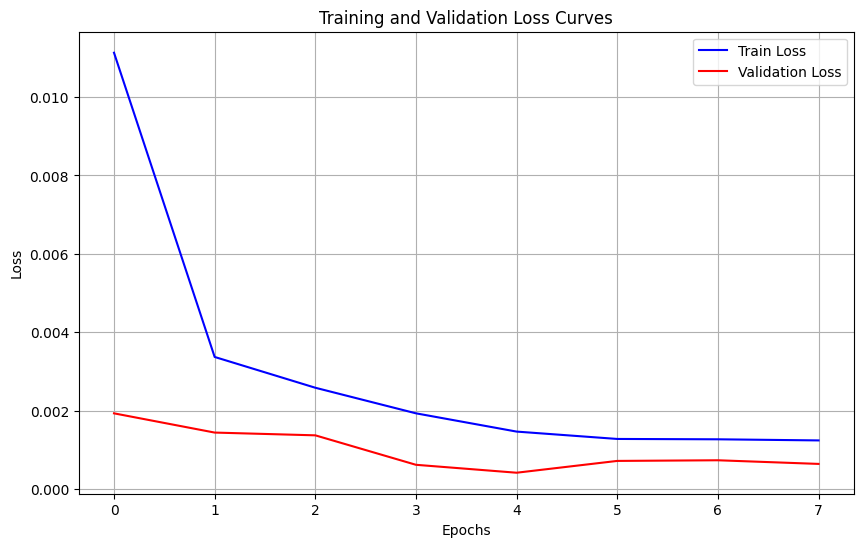

In [51]:
plot_loss_curves(history_conv1d)

### Model 2: LSTM Plot

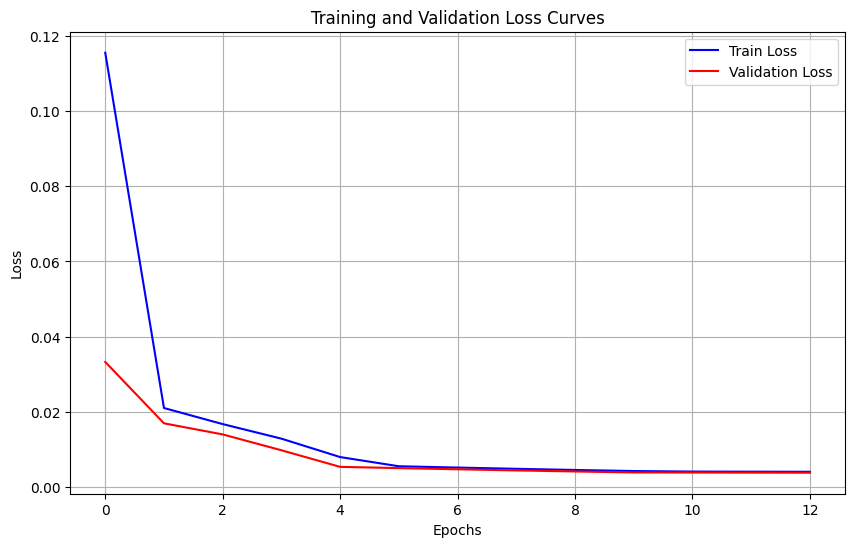

In [52]:
plot_loss_curves(history_lstm)

### Model 1: FC plot

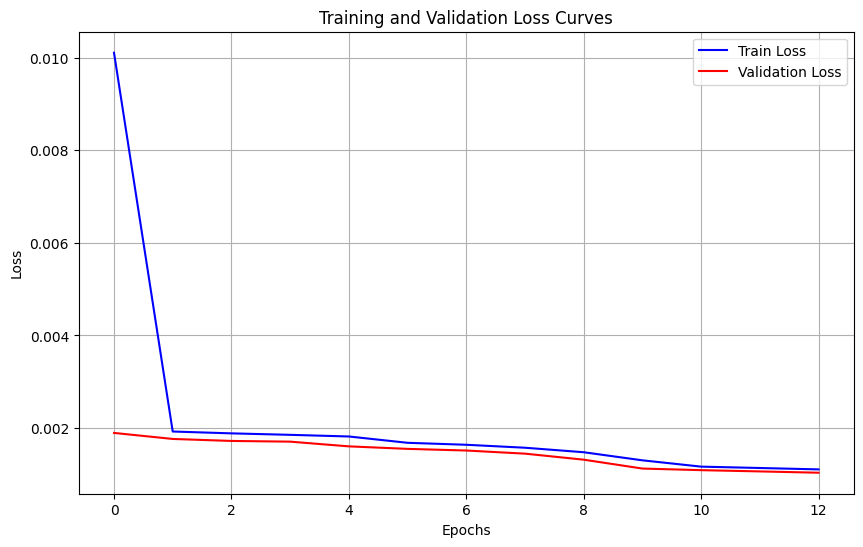

In [53]:

plot_loss_curves(history_fc)

## Step 3:

### Evaulating the test using model 1(best model)

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_recall_fscore_support

def evaluate_autoencoder(model, train_loader, val_loader, test_loader, criterion, device, is_classification=False):
    model.eval()  
    losses = {"train": 0.0, "val": 0.0, "test": 0.0}

    def compute_loss(loader, dataset_type):
        total_loss, total_samples = 0.0, 0
        all_preds, all_targets = [], []
        
        with torch.no_grad():
            for batch in loader:
                X_batch = batch[0].to(device)

                if len(X_batch.shape) == 2:  
                    X_batch = X_batch.unsqueeze(1)  

                outputs = model(X_batch)

                loss = criterion(outputs, X_batch)
                total_loss += loss.item() * X_batch.size(0)
                total_samples += X_batch.size(0)

                all_preds.append(outputs.cpu().numpy())
                all_targets.append(X_batch.cpu().numpy())

        losses[dataset_type] = total_loss / total_samples  
        return np.vstack(all_preds), np.vstack(all_targets)
    
    train_preds, train_targets = compute_loss(train_loader, "train")
    val_preds, val_targets = compute_loss(val_loader, "val")
    test_preds, test_targets = compute_loss(test_loader, "test")

    print(f"\nTraining Loss: {losses['train']:.6f}")
    print(f"Validation Loss: {losses['val']:.6f}")
    print(f"Testing Loss: {losses['test']:.6f}\n")

    if is_classification:
        train_preds = (train_preds > 0.5).astype(int)
        val_preds = (val_preds > 0.5).astype(int)
        test_preds = (test_preds > 0.5).astype(int)

        precision, recall, f1, _ = precision_recall_fscore_support(
            test_targets.flatten(), test_preds.flatten(), average="binary"
        )
        print(f"Classification Metrics:")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")
    
    else:
        test_preds = test_preds.reshape(test_preds.shape[0], -1)  # Flatten to (samples, features)
        test_targets = test_targets.reshape(test_targets.shape[0], -1)

        mae = mean_absolute_error(test_targets, test_preds)
        rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
        r2 = r2_score(test_targets, test_preds)

        print(f"Regression Metrics:")
        print(f"Mean Absolute Error (MAE): {mae:.6f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
        print(f"R-squared (R²): {r2:.6f}\n")


    return losses



In [58]:
test_metrics = evaluate_autoencoder(model_fc, train_loader, val_loader, test_loader, nn.MSELoss(), device, is_classification=False)



Training Loss: 0.001090
Validation Loss: 0.001053
Testing Loss: 0.001041

Regression Metrics:
Mean Absolute Error (MAE): 0.025312
Root Mean Squared Error (RMSE): 0.032271
R-squared (R²): 0.959293



### Reconstruction plot

In [66]:
from sklearn.metrics import mean_squared_error

def compute_reconstruction_errors(model, test_loader, device):
    model.eval() 
    reconstruction_errors = []

    with torch.no_grad():
        for batch in test_loader:
            X_batch = batch[0].to(device)  
            reconstructed = model(X_batch)
            
            mse = mean_squared_error(X_batch.cpu().numpy(), reconstructed.cpu().numpy(), multioutput='uniform_average')
            reconstruction_errors.append(mse)
    
    return np.array(reconstruction_errors)

def plot_reconstruction_error_distribution(errors):
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True, color='blue', bins=30)
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Frequency")
    plt.show()

def set_threshold(errors, percentile=95):
    threshold = np.percentile(errors, percentile)
    print(f"Anomaly Detection Threshold (Percentile {percentile}): {threshold}")
    return threshold

def detect_anomalies(errors, threshold):
    anomalies = errors > threshold
    return anomalies




/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


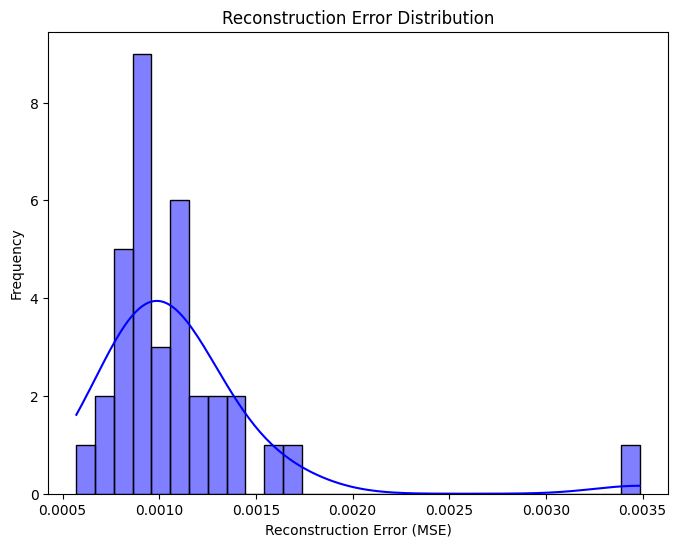

Anomaly Detection Threshold (Percentile 95): 0.0016462418949231502
Anomalies detected at indices: [23 34]


In [64]:
reconstruction_errors = compute_reconstruction_errors(model_fc, test_loader, device)

plot_reconstruction_error_distribution(reconstruction_errors)

threshold = set_threshold(reconstruction_errors, percentile=95)

anomalies = detect_anomalies(reconstruction_errors, threshold)

print("Anomalies detected at indices:", np.where(anomalies)[0])

#### 4. Discuss and analyze:

   #### - Describe your final RNN/LSTM architecture in detail (number of layers, types of layers, hidden size, dropout rate, etc.).

##### The final model is a fully connected autoencoder.  It reduces the dimension of the input to 64 neurons. The encoder consists of 3 hidden linear layers and a final linear layer that compresses it from 8 to 2. The encoder uses a ReLU activation function. The decoder takes an input size of 2 with 2 hidden layers and has a Sigmoid activation function to normalize the output between 0 and 1.

####    - Discuss your results, referencing the metrics and visualizations. Did your model achieve the expected accuracy? What were the challenges? How did hyperparameter tuning affect performance? Are there any patterns in the errors (e.g., consistent under- or over-prediction)?

##### The model ended up with an R^2 value of 0.952 and a loss of 0.001. The hyperparameter tuning prevented cases of having overfitting where the R^2 value started tending to 1 really quickly. The model achieved the expected accuracy of being over 80%. THe errors usually were really minimal and the problems we faced were mainly the case of model overfitting the data.

  #### - Discuss the strengths and limitations of using autoencoders for anomaly detection.

##### Autoencoders can capturepatterns and dependencies in the data, making them effective for detecting subtle anomalies, it is very adaptable to different types of data, can learn unsupervised and extracts features directly from the data. But the autoencoders suffer from problems such as having insuffiecient data (like in our case where we had to change the dataset a few times so as not to get r2 value of 1 really fast in under 5 epochs), if the distribution changes over time, the anomalies present in that may go unnoticed and it requires good hyperparameter tuning to avoid significant problems

### References

https://www.kaggle.com/datasets/boltzmannbrain/nab/data

https://arxiv.org/pdf/2003.05991

https://arxiv.org/abs/1606.05908

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Kisore, Indumathi  | Step 1 | 60,40  |
| Kisore, Indumathi  | Step 2 | 30,70  |
| Kisore, Indumathi | Step 3 | 50,50  |
|   | **Total** |   |